In [252]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [2]:
#Settings
# Set ipython's max row display
pd.set_option('display.max_row', 50)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# parameters block
plt.style.use("ggplot")
%matplotlib inline


plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black",
                    'xtick.color' : "black",
                    'ytick.color' : "black"})

In [ ]:
import tmdbsimple as tds
import pdb

keys = pd.read_csv('keys.txt')
keys['kDb3'][0]
tds.API_KEY = keys['kDb3'][0]

In [96]:
merged_movie_r_df_num = pd.read_csv('data/merged_movies_and_ratings.csv')

In [118]:
print('Parsing Movies')
ml_m_df = pd.read_csv("ml-25m/movies.csv")
print(ml_m_df.info())
print('\n')

Parsing Movies
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None




In [120]:
ml_m_df.drop(columns=['genres'], inplace=True)

In [121]:
ml_m_df # Using this df as a reference link.

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
62418,209157,We (2018)
62419,209159,Window of the Soul (2001)
62420,209163,Bad Poems (2018)
62421,209169,A Girl Thing (2001)


In [97]:
merged_movie_r_df_num.drop(columns=['Unnamed: 0'], inplace=True)
merged_movie_r_df_num.drop(columns=['imdbId', 'tmdbId', 'timestamp'], inplace=True)
merged_movie_r_df_num['startYear'] = merged_movie_r_df_num['startYear'].astype('uint32')
merged_movie_r_df_num['timeyear'] = merged_movie_r_df_num['timeyear'].astype('uint32')
dfui8c = ['gnr_Action', 'gnr_Adult', 'gnr_Adventure', 'gnr_Animation', 'gnr_Biography', 'gnr_Comedy',
          'gnr_Crime', 'gnr_Documentary', 'gnr_Drama', 'gnr_Family', 'gnr_Fantasy', 'gnr_Film-Noir',
          'gnr_History', 'gnr_Horror', 'gnr_Music', 'gnr_Mystery', 'gnr_Romance', 'gnr_Sci-Fi', 'gnr_Sport',
          'gnr_Thriller', 'gnr_War', 'gnr_Western', 'original_language_en', 'original_language_hi',
          'original_language_it', 'original_language_ja', 'original_language_kl', 'original_language_lg',
          'original_language_mt', 'original_language_os', 'original_language_ps', 'original_language_st',
          'original_language_sv', 'original_language_ti']
for ui8col in dfui8c:
    merged_movie_r_df_num[ui8col] = merged_movie_r_df_num[ui8col].astype('uint8')
merged_movie_r_df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24575286 entries, 0 to 24575285
Data columns (total 47 columns):
 #   Column                Dtype  
---  ------                -----  
 0   budget                int64  
 1   popularity            float64
 2   revenue               int64  
 3   vote_average          float64
 4   vote_count            int64  
 5   startYear             uint32 
 6   runtimeMinutes        float64
 7   averageRating         float64
 8   numVotes              int64  
 9   gnr_Action            uint8  
 10  gnr_Adult             uint8  
 11  gnr_Adventure         uint8  
 12  gnr_Animation         uint8  
 13  gnr_Biography         uint8  
 14  gnr_Comedy            uint8  
 15  gnr_Crime             uint8  
 16  gnr_Documentary       uint8  
 17  gnr_Drama             uint8  
 18  gnr_Family            uint8  
 19  gnr_Fantasy           uint8  
 20  gnr_Film-Noir         uint8  
 21  gnr_History           uint8  
 22  gnr_Horror            uint8  
 23  gnr_M

# Compression successful!
From 9.2 GB down to 3.0 GB - a reduction down to just under 33%!

In [98]:
merged_movie_r_df_num.nunique()

budget                    1346
popularity               14128
revenue                   8323
vote_average                87
vote_count                3036
startYear                  111
runtimeMinutes             224
averageRating               82
numVotes                 14950
gnr_Action                   2
gnr_Adult                    2
gnr_Adventure                2
gnr_Animation                2
gnr_Biography                2
gnr_Comedy                   2
gnr_Crime                    2
gnr_Documentary              2
gnr_Drama                    2
gnr_Family                   2
gnr_Fantasy                  2
gnr_Film-Noir                2
gnr_History                  2
gnr_Horror                   2
gnr_Music                    2
gnr_Mystery                  2
gnr_Romance                  2
gnr_Sci-Fi                   2
gnr_Sport                    2
gnr_Thriller                 2
gnr_War                      2
gnr_Western                  2
original_language_en         2
original

In [100]:
merged_movie_r_df_num.drop(columns = ['original_language_kl', 'original_language_lg', 'original_language_mt',
                                      'original_language_os', 'original_language_ps', 'original_language_st',
                                      'original_language_ti'], inplace = True)

In [102]:
merged_movie_r_df_num.info() # now down to under 30.5% size.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24575286 entries, 0 to 24575285
Data columns (total 40 columns):
 #   Column                Dtype  
---  ------                -----  
 0   budget                int64  
 1   popularity            float64
 2   revenue               int64  
 3   vote_average          float64
 4   vote_count            int64  
 5   startYear             uint32 
 6   runtimeMinutes        float64
 7   averageRating         float64
 8   numVotes              int64  
 9   gnr_Action            uint8  
 10  gnr_Adult             uint8  
 11  gnr_Adventure         uint8  
 12  gnr_Animation         uint8  
 13  gnr_Biography         uint8  
 14  gnr_Comedy            uint8  
 15  gnr_Crime             uint8  
 16  gnr_Documentary       uint8  
 17  gnr_Drama             uint8  
 18  gnr_Family            uint8  
 19  gnr_Fantasy           uint8  
 20  gnr_Film-Noir         uint8  
 21  gnr_History           uint8  
 22  gnr_Horror            uint8  
 23  gnr_M

In [103]:
merged_movie_r_df_num.to_csv('data/merged_movies_and_ratings_reduced.csv')

In [153]:
merged_movie_r_df_num['revenue'].median()

91258000.0

In [152]:
merged_movie_r_df_num['budget'].median() < merged_movie_r_df_num['revenue'].median()

True

In [ ]:
df['color'] = np.where(((df.A < borderE) & ((df.B - df.C) < ex)), 'r', 'b')

In [ ]:
np.where

In [159]:
def money_impute(mudf):
    """
    Input: merged dataframe of user ratings and their corresponding movie
    Output: this dataframe but with imputed budget and revenue, based on the median
    """
    mudf = mudf.copy()
    bm = mudf['budget'].median()
    rm = mudf['revenue'].median()
    
    mudf['budget'] = mudf['budget'].apply(lambda x: x if x>0 else bm)
    mudf['revenue'] = mudf['revenue'].apply(lambda x: x if x>0 else rm)
    
    # Entries were rev is 0 and budget less than rm, assign rm.
    #mudf['revenue'] = np.where(((mudf.revenue <= 0) & (mudf.budget <= rm), rm, mudf.revenue))
                               
    # If the budget was greater than rm, assign the budget for what 0 remain.
    #mudf['revenue'] = np.where(((mudf.revenue <= 0) & (mudf.budget > rm), mudf.budget, mudf.revenue))

    return mudf

In [160]:
merged_movie_r_df_imp = money_impute(merged_movie_r_df_num)

In [163]:
merged_movie_r_df_num[merged_movie_r_df_num['budget']>merged_movie_r_df_num['revenue']]

,budget,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv,userId,movieId,rating,timeyear
5744,21000000,7.881,12136938,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,177,479,3.0,1999
5745,21000000,7.881,12136938,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,304,479,3.0,2000
5746,21000000,7.881,12136938,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,526,479,3.0,1997
5747,21000000,7.881,12136938,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,695,479,3.0,1999
5748,21000000,7.881,12136938,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,772,479,2.0,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24575167,5000000,32.277,0,3.5,785,2019,84.0,3.05,21868,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,10919,207229,1.0,2019
24575168,5000000,32.277,0,3.5,785,2019,84.0,3.05,21868,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,15044,207229,3.5,2019
24575169,5000000,32.277,0,3.5,785,2019,84.0,3.05,21868,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,29542,207229,0.5,2019
24575170,5000000,32.277,0,3.5,785,2019,84.0,3.05,21868,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,86462,207229,1.5,2019


In [168]:
merged_movie_r_df_imp[merged_movie_r_df_imp['budget']==merged_movie_r_df_num['budget'].median()]

,budget,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv,userId,movieId,rating,timeyear
0,22000000.0,11.407,91258000.0,3.40,132,1988,72.0,3.75,6290,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,357,4470,4.0,2013
1,22000000.0,11.407,91258000.0,3.40,132,1988,72.0,3.75,6290,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,847,4470,4.0,2019
2,22000000.0,11.407,91258000.0,3.40,132,1988,72.0,3.75,6290,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1991,4470,4.0,2014
3,22000000.0,11.407,91258000.0,3.40,132,1988,72.0,3.75,6290,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2887,4470,0.5,2003
4,22000000.0,11.407,91258000.0,3.40,132,1988,72.0,3.75,6290,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3469,4470,4.0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24575281,22000000.0,7.609,91258000.0,3.65,195,2019,107.0,3.15,2109,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,11507,208683,3.5,2019
24575282,22000000.0,7.609,91258000.0,3.65,195,2019,107.0,3.15,2109,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,66268,208683,3.0,2019
24575283,22000000.0,18.746,91258000.0,2.15,15,2019,84.0,1.70,535,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,46264,208915,3.5,2019
24575284,22000000.0,2.556,91258000.0,1.50,1,2019,93.0,1.70,78,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,105679,207714,3.0,2019


# Rough imputation of missing budget and revenue finished
It could be done better.

In [165]:
merged_movie_r_df_imp.shape

(24575286, 40)

In [164]:
merged_movie_r_df_imp[merged_movie_r_df_imp['budget']>merged_movie_r_df_imp['revenue']]

,budget,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv,userId,movieId,rating,timeyear
5744,21000000.0,7.881,12136938.0,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,177,479,3.0,1999
5745,21000000.0,7.881,12136938.0,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,304,479,3.0,2000
5746,21000000.0,7.881,12136938.0,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,526,479,3.0,1997
5747,21000000.0,7.881,12136938.0,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,695,479,3.0,1999
5748,21000000.0,7.881,12136938.0,3.2,188,1993,110.0,3.35,15611,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,772,479,2.0,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24575139,22000000.0,6.634,1294480.0,3.7,23,2019,135.0,4.05,1007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,86667,207077,5.0,2019
24575140,22000000.0,6.634,1294480.0,3.7,23,2019,135.0,4.05,1007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,90101,207077,5.0,2019
24575141,22000000.0,6.634,1294480.0,3.7,23,2019,135.0,4.05,1007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,91400,207077,4.0,2019
24575142,22000000.0,6.634,1294480.0,3.7,23,2019,135.0,4.05,1007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,103456,207077,3.5,2019


In [114]:
def merged_split_user_item(mudf):
    """
    Input: merged dataframe of user ratings and their corresponding movie
    Output: two split dataframes containing only users and only movies respectively
    Purpose: creating split data to test use of LightFM
    """
    udf = mudf[['userId', 'movieId', 'rating', 'timeyear']]
    mdf = mudf.drop(columns=['userId', 'rating', 'timeyear']).drop_duplicates(subset='movieId')
    
    return udf.sort_values('userId').reset_index(drop=True), mdf.sort_values('movieId').reset_index(drop=True)

In [169]:
#creating separate dataframes for vectorization
user_r_df, movie_df = merged_split_user_item(merged_movie_r_df_imp)

In [123]:
ml_m_df[ml_m_df['movieId']==208683]

,movieId,title
62301,208683,The Man Without Gravity (2019)


In [175]:
movie_df.drop(columns = ['vote_average', 'vote_count'], inplace=True) # Less popular platform has less useful content.

In [178]:
movie_df['runtimeMinutes'].max()

808.0

# Movie Metadata Commentary
## Context only items
These are not recommended for user profile preference and should only be used in reporting movie information on UI display when returning general movie information.
budget, revenue

## Possible match aids
These are recommended as possibly helpful fields for recommending in some algorithms
popularity, startYear, runtimeMinutes, averageRating, numVotes

## Total columns to separate:
['budget', 'revenue', 'popularity', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes']

In [185]:
def movie_split_away_context(mdf, si=True):
    """
    Input: movie dataframe of all movie data
    Output: two split dataframes, one containing only fields common in the user vector, the other containing only
      context data
    Purpose: creating split data to test use of LightFM
    """
    mdf = mdf.copy()
    ctdf = mdf[['movieId','budget', 'revenue', 'popularity', 'startYear', 'runtimeMinutes',
                'averageRating', 'numVotes']]
    cmdf = mdf.drop(columns=['budget', 'revenue', 'popularity', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes'])
    ctdf.sort_values('movieId')
    cmdf.sort_values('movieId')
    
    if si==True:
        ctdf.set_index('movieId')
        cmdf.set_index('movieId')
    
    return cmdf, ctdf

In [232]:
movie_vector_df, movie_context_df = movie_split_away_context(movie_df)

In [187]:
movie_vector_df

,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv,movieId
0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,3
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36862,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,209135
36863,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,209145
36864,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,209147
36865,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,209157


In [241]:
def expandvectormax(df, s=100):
    """
    Inputs:
    df: the movie vector dataframe
    s: scalar to multiply the vector
    """
    df = df.copy()
    df.iloc[:,:27] = df.iloc[:,:27].mul(s) # This alters the original dataframe so a copy should be established.
    return df

In [257]:
movie_vector_dfe = expandvectormax(movie_vector_df, s=100)
movie_vector_dfe.set_index('movieId', inplace=True)

In [258]:
movie_vector_dfe

,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_sv
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,100,100,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0
2,0,0,100,0,0,100,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0
3,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0
4,0,0,0,0,0,100,0,0,100,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0
5,0,0,0,0,0,100,0,0,0,100,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209135,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209145,0,0,0,0,0,0,0,0,100,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209147,0,0,0,0,0,0,100,0,100,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0


In [254]:
#ufv = user vector fields, the fields used in a user vector
uvf = list(movie_vector_dfe.iloc[:,:27].columns)

In [255]:
uvf

['gnr_Action',
 'gnr_Adult',
 'gnr_Adventure',
 'gnr_Animation',
 'gnr_Biography',
 'gnr_Comedy',
 'gnr_Crime',
 'gnr_Documentary',
 'gnr_Drama',
 'gnr_Family',
 'gnr_Fantasy',
 'gnr_Film-Noir',
 'gnr_History',
 'gnr_Horror',
 'gnr_Music',
 'gnr_Mystery',
 'gnr_Romance',
 'gnr_Sci-Fi',
 'gnr_Sport',
 'gnr_Thriller',
 'gnr_War',
 'gnr_Western',
 'original_language_en',
 'original_language_hi',
 'original_language_it',
 'original_language_ja',
 'original_language_sv']

In [259]:
user_r_df['userId'].max() # Let all new user profiles begin past this maximum
# Current max: 162541

162541

In [189]:
#user_r_dfv = user_r_df.set_index('userId')

# Matrix factorization with dataframes
## numpy operation
numpy dot multiplication works on both ndarrays and dataframes. Typically the user and item columns become the index for this operation so all user and item fields are identical.
## Function usage
Using dot multiplication to find the user's initial preference based on their initial starting values can be done in a couple ways. Where U is the user dataframe and M is the movie dataframe, with users and movies assigned to their respective index, the multiplication of a single vector U.loc[user] with M.loc[movie] returns a signle number that represents that user's preference strength for that movie.
This can also be done with a batch of movies to one user by multiply U.loc[user] with the transpose of the entire movie dataframe.
This can even be done with all users and all movies by multiplying the entire user dataframe with the transpose of the entire movie dataframe!

In [256]:
def set_user_weights(uid, uvf=uvf, s=100, ud=None, sdf=None, m='set'):
    """
    NOTE: Needs more work.
    Function description: Takes in a dictionary of initial user data. Returns...
      a vector of the user's preferences
    
    uid = user ID
    ufv = user vector fields
    ud = update dictionary
    sdf = source dataframe. If None, builds a new dataframe. If a dataframe is passed in, the new user data
      is added to it.
    m = mode. 'set' creates or replaces data at a specific user index.
    """
    nudl = list()
    ndf=None
    
    ndf = pd.DataFrame(columns=uvf)
    for field in uvf:
        nudl.append(math.floor(s/2)) # expecting columns not to change in order or number
    if sdf:
        ndf = sdf.copy()
    ndf.loc[uid] = nudl #If the id is new, adds a new row. If the id exists it replaces this row.
    return ndf

In [11]:
merged_movie_r_df_num['rating'].value_counts()

4.0    6536999
3.0    4830578
5.0    3544464
3.5    3115160
4.5    2157474
2.0    1618984
2.5    1239146
1.0     762660
1.5     391687
0.5     378134
Name: rating, dtype: int64

In [192]:
user_r_df

,userId,movieId,rating,timeyear
0,1,2692,5.0,2006
1,1,8154,5.0,2006
2,1,32591,5.0,2006
3,1,1237,5.0,2006
4,1,5952,4.0,2006
...,...,...,...,...
24575281,162541,1210,3.5,2009
24575282,162541,2628,3.0,2009
24575283,162541,5378,2.5,2009
24575284,162541,318,4.0,2009


In [12]:
def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""

    return round(number * 2) / 2

In [14]:
round_of_rating(2.3)

2.5

In [15]:
merged_movie_r_df_sample = merged_movie_r_df_num.sample(n=400000, random_state=np.random.RandomState())

# MetaUser generation and selection
## Generation
This function could be used to thwart the cold-start problem and search against recommendations. The function takes in a particular movie and rating, then pulls in the average of all movie attributes of all movies such users watch. This means that when a user gives a single movie a rating, value weights for all attributes a movie can have is applied to that user. Recommendation discovery then based off this information.
## Selection
If the user only selects a particular movie without giving a rating, assume they want to give it a high rating. Return results for the highest metauser score found for that movie. As the user selects more movies, the metauser results are then averaged together further into the unique blend of values that define this user.

In [62]:
# Seeking user info for those who saw a particular movie and rated it 0.5
testdf = merged_movie_r_df_num[(merged_movie_r_df_num['rating']==0.5) & (merged_movie_r_df_num['movieId']==4470)]

In [56]:
testdf['userId'] # Users who rated this particular movie low.

3        2887
46      29697
147     90068
169    106897
199    123711
202    126721
Name: userId, dtype: int64

In [48]:
testdf.drop(columns=['tmdbId', 'imdbId'], inplace=True) # This isn't important, remove.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
# Finding all movie rating data for the users who rated that previous movie with a 0.5
aggtdf = merged_movie_r_df_num[merged_movie_r_df_num['userId'].isin(testdf['userId'])]

In [59]:
aggtdf

,budget,tmdbId,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_kl,original_language_lg,original_language_mt,original_language_os,original_language_ps,original_language_st,original_language_sv,original_language_ti,userId,movieId,rating,timestamp,imdbId,timeyear
3,0,2,11.407,0,3.40,132,1988,72.0,3.75,6290,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2887,4470,0.5,1046382868,94675,2003
46,0,2,11.407,0,3.40,132,1988,72.0,3.75,6290,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,29697,4470,0.5,1187955783,94675,2007
147,0,2,11.407,0,3.40,132,1988,72.0,3.75,6290,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,90068,4470,0.5,1112737902,94675,2005
169,0,2,11.407,0,3.40,132,1988,72.0,3.75,6290,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,106897,4470,0.5,1202236607,94675,2008
199,0,2,11.407,0,3.40,132,1988,72.0,3.75,6290,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,123711,4470,0.5,1463325700,94675,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24446923,0,397243,32.460,5972942,3.35,2911,2016,86.0,3.40,101439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,123711,165603,1.5,1484973215,3289956,2017
24449341,5980000,398535,7.359,14900000,3.55,97,2016,148.0,3.90,27495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,123711,160301,0.5,1466316634,4434004,2016
24462376,0,400605,9.574,0,2.60,128,2016,96.0,2.40,2754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,123711,160428,0.5,1480027699,5481404,2016
24508638,0,433244,10.614,0,2.65,293,2017,104.0,2.55,7045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,123711,168126,2.0,1484877675,5577742,2017


In [61]:
aggtdf['rating'].value_counts()

0.5    1954
1.0     896
3.0     877
2.0     746
2.5     543
4.0     534
1.5     468
3.5     291
5.0     280
4.5     277
Name: rating, dtype: int64

In [63]:
((0.5*1954)+(1.0*896)+(3.0*877)+(2.0*746)+(2.5*543)+(4.0*534)+(1.5*468)+(3.5*291)+(5.0*280)+(4.5*277))/6866

2.0181328284299447

In [ ]:
aggtdf.drop(columns=['tmdbId', 'userId', 'movieId', ])

In [ ]:
df.groupby("Gender").agg({'Age' : 'mean', 'Salary' : 'mean', 'Yr_exp': 'mean'})

In [ ]:
metausertest = 

In [ ]:
def gen_metausers(fr_df, umr_dct):
    """
    Takes in a full ratings dataframe containing all relevant movie, user and rating data.
    
    Returns a dataframe with summary users (metausers), groups by movie and rating bucket.
    
    Operations: Generate a metauser profile based on a rating given to a particular movie.
    
    Inputs:
    fr_df = full ratings dataframe (pandas dataframe): a frame containing all user ratings
      and their corresponding movie data.
      
    umr_dct = user's movie ratings dictionary: a dictionary containing all of the user's identified movies
      and their given rating. If a movie is given no rating, assume 5. If no ratings of 5 are found for
      a given movie, seek the next lowest score.
      
    Outputs:
    mud_df = metauser data (pandas dataframe): returns a pandas dataframe of all rating buckets per movie
      and their averaged field values, a form of meta user.
    """
    
    
    

In [16]:
merged_movie_r_df_sample

,budget,tmdbId,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_kl,original_language_lg,original_language_mt,original_language_os,original_language_ps,original_language_st,original_language_sv,original_language_ti,userId,movieId,rating,timestamp,imdbId,timeyear
6215165,90000000,686,15.819,171120329,3.70,3094,1997,150.0,3.70,257175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,107460,1584,4.0,1448606172,118884,2015
21037197,134000,25508,8.391,4000000,3.50,332,1942,73.0,3.65,20381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,95455,7713,0.5,1265848069,34587,2010
16413057,15000000,10323,15.288,41092328,3.45,490,1981,118.0,3.45,41494,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,69424,5540,3.0,1172205413,82186,2007
16061917,37000000,10096,20.808,96455697,3.35,3824,2004,98.0,3.10,170186,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,152782,7444,3.0,1402552822,337563,2014
23700396,40000000,193756,21.409,149295601,3.70,3103,2013,121.0,3.75,269189,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,17407,107069,4.0,1390519440,1091191,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562646,0,9411,11.311,25232289,3.40,870,1998,124.0,3.50,76402,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,26169,1754,4.0,941541291,119099,1999
11725646,30000000,4476,14.417,160638883,3.70,1727,1994,133.0,3.80,151519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,55715,266,3.0,836912829,110322,1996
16423183,0,10328,10.326,85313124,3.30,855,1985,117.0,3.35,57927,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,36175,2407,3.0,938899645,88933,1999
1176986,19000000,105,35.443,381109762,4.15,14860,1985,116.0,4.25,1074403,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,155584,1270,5.0,923131877,88763,1999


In [17]:
merged_movie_r_df_sample.drop(columns=['timestamp', 'imdbId'], inplace=True)

In [19]:
merged_movie_r_df_sample['vote_average'].min()

0.0

In [20]:
rec_sample_sdf = spark.createDataFrame(merged_movie_r_df_sample)

In [68]:
rec_sample_sdf.show()

+---------+------+----------+----------+------------+----------+---------+--------------+-------------+--------+----------+---------+-------------+-------------+-------------+----------+---------+---------------+---------+----------+-----------+-------------+-----------+----------+---------+-----------+-----------+----------+---------+------------+-------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------+------+--------+
|   budget|tmdbId|popularity|   revenue|vote_average|vote_count|startYear|runtimeMinutes|averageRating|numVotes|gnr_Action|gnr_Adult|gnr_Adventure|gnr_Animation|gnr_Biography|gnr_Comedy|gnr_Crime|gnr_Documentary|gnr_Drama|gnr_Family|gnr_Fantasy|gnr_Film-Noir|gnr_History|gnr_Horror|gnr_Music|gnr_Mystery|gnr_Romance|gnr_Sci-Fi|gnr_Sport|gnr_Thril

In [69]:
print('Number of unique users: {}'.format(rec_sample_sdf.select('userId').distinct().count()))
print('Number of unique movies: {}'.format(rec_sample_sdf.select('movieId').distinct().count()))
print('Number of rating: {}'.format(rec_sample_sdf.count()))
# The density of this sample matrix is 
rec_sample_sdf.count()/(rec_sample_sdf.select('userId').distinct().count()*rec_sample_sdf.select('movieId').distinct().count())

Number of unique users: 109612
Number of unique movies: 14263
Number of rating: 400000


0.0002558532906938132

In [70]:
#Making split for sample
train, test = rec_sample_sdf.randomSplit([0.8, 0.2], seed=10)
train.count(), test.count()

(319855, 80145)

Max Ratings: 302
Min Ratings: 1


<AxesSubplot:>

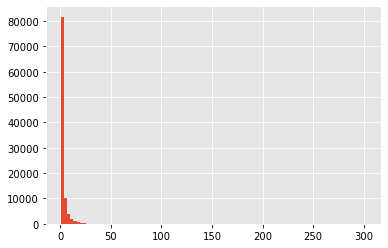

In [71]:
user_count = train.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 1102
Min Ratings: 1


<AxesSubplot:>

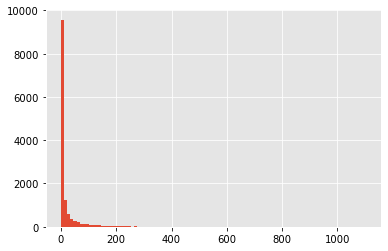

In [72]:
movie_count = train.groupBy('movieId').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 89
Min Ratings: 1


<AxesSubplot:>

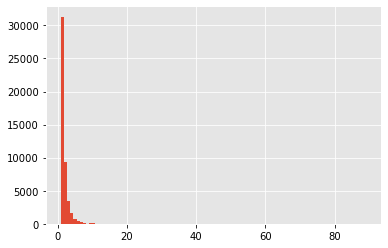

In [73]:
user_count = test.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 266
Min Ratings: 1


<AxesSubplot:>

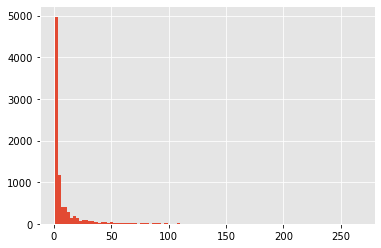

In [74]:
movie_count = test.groupBy('movieId').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

In [75]:
als_model = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender = als_model.fit(train)

# This kind sample will need to be recreated from a class object that holds user parameters.
The ideal goal is to be able to catalogue distinct user profiles that each hold their information. The goal is to write their profiles to file/database to be able to call them as required.

In [76]:
merged_movie_r_df_sample

,budget,tmdbId,popularity,revenue,vote_average,vote_count,startYear,runtimeMinutes,averageRating,numVotes,gnr_Action,gnr_Adult,gnr_Adventure,gnr_Animation,gnr_Biography,gnr_Comedy,gnr_Crime,gnr_Documentary,gnr_Drama,gnr_Family,gnr_Fantasy,gnr_Film-Noir,gnr_History,gnr_Horror,gnr_Music,gnr_Mystery,gnr_Romance,gnr_Sci-Fi,gnr_Sport,gnr_Thriller,gnr_War,gnr_Western,original_language_en,original_language_hi,original_language_it,original_language_ja,original_language_kl,original_language_lg,original_language_mt,original_language_os,original_language_ps,original_language_st,original_language_sv,original_language_ti,userId,movieId,rating,timeyear
6215165,90000000,686,15.819,171120329,3.70,3094,1997,150.0,3.70,257175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,107460,1584,4.0,2015
21037197,134000,25508,8.391,4000000,3.50,332,1942,73.0,3.65,20381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,95455,7713,0.5,2010
16413057,15000000,10323,15.288,41092328,3.45,490,1981,118.0,3.45,41494,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,69424,5540,3.0,2007
16061917,37000000,10096,20.808,96455697,3.35,3824,2004,98.0,3.10,170186,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,152782,7444,3.0,2014
23700396,40000000,193756,21.409,149295601,3.70,3103,2013,121.0,3.75,269189,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,17407,107069,4.0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562646,0,9411,11.311,25232289,3.40,870,1998,124.0,3.50,76402,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,26169,1754,4.0,1999
11725646,30000000,4476,14.417,160638883,3.70,1727,1994,133.0,3.80,151519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,55715,266,3.0,1996
16423183,0,10328,10.326,85313124,3.30,855,1985,117.0,3.35,57927,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,36175,2407,3.0,1999
1176986,19000000,105,35.443,381109762,4.15,14860,1985,116.0,4.25,1074403,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,155584,1270,5.0,1999


In [77]:
data = [(51787, 524)]
columns = ('userId', 'movieId')
one_row_spark_df = spark.createDataFrame(data, columns)
one_row_spark_df.show()

+------+-------+
|userId|movieId|
+------+-------+
| 51787|    524|
+------+-------+



In [78]:
user_factor_df = recommender.userFactors.filter('id = 51787')
item_factor_df = recommender.itemFactors.filter('id = 524')

In [79]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [80]:
np.dot(user_factors, item_factors)

2.3797861873330373

In [81]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
| 51787|    524| 2.3797863|
+------+-------+----------+



In [85]:
# Get the top movies for a user 1

recommender.recommendForUserSubset(one_row_spark_df, 10).show(10, False)

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                     |
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|51787 |[[109388, 4.212019], [59844, 4.0978656], [136024, 3.8888369], [862, 3.7774658], [178311, 3.626557], [5759, 3.615925], [95425, 3.5492938], [176919, 3.5090258], [54290, 3.499481], [2673, 3.4602578]]|
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Andrew says: LightFM
Research this "state of the art recommender system" and its possible use in python.

# Recommender output summary and next steps
The recommender can target a single user within the dataframe and deliver a recommendation for them. Try to find a way to recommend to a user who is not within the dataset.

Possible solution: https://datascience.stackexchange.com/questions/14744/spark-als-recommending-for-new-users
Fold-In explanation:


Lots of questions here. First, for a truly new user with no data, there is no way to use a recommender model. If you have literally no information on the user, the only thing you can do is provide some default recommendations.

Of course, once you have any data, and you can rebuild the model to incorporate the user, you can make recommendations. You can do that in Spark but you already know that. This will take too long if you need to add information about new users at runtime. The technique you want is called "fold-in", used to figure out what the new user vector is (approximately) given the items the user interacts with. It's just some linear algebra and does follow from the equation you give.



In [64]:
predictions = recommender.transform(test)

In [65]:
predictions.describe().show()

+-------+-------------------+------------------+-----------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+------------------+-----------------+-----------+
|summary|             b

In [ ]:
# add the implicit rating column

train = train.withColumn("imp_rating", lit(1))
train.show(5)

In [ ]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='imp_rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [ ]:
# Looking at the recommendations for user 1 to compare to what the explicit gave back 
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

In [ ]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [ ]:
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

In [ ]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [ ]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [ ]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [ ]:
predictions_df.head()

In [ ]:
predictions_df.describe()

In [ ]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

In [ ]:
predictions_df.head()

In [ ]:

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

#### Additional Content

In [ ]:
def rank_score(df):
    df2 = df.copy()
    df2['rank'] = df2.groupby("userId")["prediction"].rank("dense", ascending=False, na_option='top') -1
    df2 = df2.join(df2.groupby("userId")["rank"].max(), on='userId', rsuffix='_max')
    df2['pct_rank'] = df2['rank']/df2['rank_max']
    
    return np.sum(df2['interactions']*df2['pct_rank'])/np.sum(df2['interactions'])
    

In [ ]:
implicit_predictions = recommender_imp.transform(test)

In [ ]:
implicit_predictions_df = implicit_predictions.toPandas()

In [ ]:
implicit_predictions_df.info()

In [ ]:
implicit_predictions_df = implicit_predictions_df.fillna(0)

In [ ]:
implicit_predictions_df

In [ ]:
# Rename column 'rating' to 'interactions' as that is what we are looking for.
implicit_predictions_df.rename(columns={'rating':'interactions'}, inplace=True)

In [ ]:
implicit_predictions_df

In [ ]:
rank_score(implicit_predictions_df)

# User Account Management
## Main Function Objects
### Data written to file
#### The user record
This data is to be initialized by the user, with a minimum of a single item's key values. This creates a record to be saved to file. This record will be loaded in every time the user "signs in", which means loads their saved record. This record is instantiated into the class, where its methods enable adding/deleting items, and using the recommender to find more items.
#### Record Item Searching and declaration
Using a variety of searching (some based on regex), the user can locate items to add to their profile. At minimum is searching via title, but the more methods available the better. The user should be able to search by genre, name, and potentially weighted tags. This is to be created on availability of time. MVP: title
#### Record completion and imputation
As the user finds items through searching, ensure all fields saved to the user are functional.
### Recommender
#### Recommendation Search
The recommender will be called upon the moment the user class executes the function method to load all its item data into the model. Thus the user will receive a prediction based on their total complete record.
#### Archiving the result
Present the user with the choice to save items which are recommended. These will be added to their profile, thus increasing their unique data.
# User Interface and Display
## Basic display linking
For the next part of the project, the user should have comfortable display. Movie title and summary information is minimum, but additional data can be used to show descriptions, tags, keywords, and movie poster art. Many of these fields are often found NULL in their source data, and as such error handling and data processing must be present to ensure the query returns all required UI items without breaking functionality. In case of constraint toggle a simple mode to ensure verbose content can be skipped.

# Data Concept: MetaUser
## Overall dataset compression and feature weighting
By taking an average result of all users per bucket of rating range of a movie within 1.0 (0 to 1, 1 to 2, 2 to 3, etc), a MetaUser can be created.
The score bucket becomes its own kind of user record, and all values of continuous float and dummy binary 0/1 become an average. This reduces data within the prediction model structure, which could potentially increase the speed of predictions. The premise: some people are very similar to others.

## A user record with multiple items saved can form a MetaUser
As a user collects movies and rates them, this item's user data can easily be matched to a MetaUser. This results in a quick prediction.